# Hands On : Cats vs Dogs
- Team : Machine Learning GDGoC : Universitas Sriwijaya
- Topic : Deep Learning - Computer Vision
- Notebook Creator : Aditya Bayhaqie
- [Dataset](https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification)

## Library Preparation


In [26]:
!pip install torch torchvision numpy matplotlib kaggle

**Reasoning**:
Import the necessary libraries for the subsequent steps.



In [27]:
# Import necessary libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

## Data Acquisition


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTANT**

Before Proceeding Further, please save your kaggle API file to your Drive first to continue the Hands-on

[Youtube Tutorial](https://youtu.be/yEXkEUqK52Q?si=nkSNHTzvdWoyk1O3)


In [29]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [30]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [31]:
! chmod 600 ~/.kaggle/kaggle.json

In [32]:
! kaggle datasets download samuelcortinhas/cats-and-dogs-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification
License(s): CC0-1.0
cats-and-dogs-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [33]:
zip_file_path = 'cats-and-dogs-image-classification.zip'
extract_dir = 'cats_and_dogs_dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Dataset extracted to cats_and_dogs_dataset


## Data Augmentation

In [34]:
# List the contents of the extracted directory to verify the structure
extracted_contents = os.listdir(extract_dir)
print(f"Contents of {extract_dir}: {extracted_contents}")

# Based on the likely structure, correct the paths
train_dir = os.path.join(extract_dir, 'train')
test_dir = os.path.join(extract_dir, 'test') # Assuming 'test' is the directory name for the testing set

# Redefine image transformations for training and testing
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet standards
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet standards
])

Contents of cats_and_dogs_dataset: ['test', 'train']


In [40]:
# Create image datasets for training and testing
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Define batch size for data loaders
batch_size = 32

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Training and testing datasets and data loaders created with corrected paths.")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")

Training and testing datasets and data loaders created with corrected paths.
Number of training images: 557
Number of testing images: 140


## Model building


In [51]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the flattened features after pooling
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 64 * 28 * 28)

        # Pass through fully connected layers
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate the model
model = SimpleCNN()

# Print the model architecture
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

## Model training

In [52]:
# Set up the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move the model to the device

# Define the loss function (Cross-Entropy Loss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer is a good choice)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

# Define the number of training epochs
num_epochs = 20  # You can adjust this number

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the training data loader
    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()


    # Calculate average training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_predictions

    # Print training loss and accuracy for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("Finished Training")

Epoch [1/20], Loss: 0.6961, Accuracy: 49.37%
Epoch [2/20], Loss: 0.6792, Accuracy: 55.83%
Epoch [3/20], Loss: 0.6747, Accuracy: 60.14%
Epoch [4/20], Loss: 0.6840, Accuracy: 55.30%
Epoch [5/20], Loss: 0.6717, Accuracy: 55.12%
Epoch [6/20], Loss: 0.6617, Accuracy: 59.78%
Epoch [7/20], Loss: 0.6648, Accuracy: 60.32%
Epoch [8/20], Loss: 0.6544, Accuracy: 62.12%
Epoch [9/20], Loss: 0.6701, Accuracy: 60.32%
Epoch [10/20], Loss: 0.6496, Accuracy: 63.20%
Epoch [11/20], Loss: 0.6537, Accuracy: 61.22%
Epoch [12/20], Loss: 0.6528, Accuracy: 63.02%
Epoch [13/20], Loss: 0.6428, Accuracy: 65.53%
Epoch [14/20], Loss: 0.6514, Accuracy: 63.55%
Epoch [15/20], Loss: 0.6496, Accuracy: 63.38%
Epoch [16/20], Loss: 0.6416, Accuracy: 64.45%
Epoch [17/20], Loss: 0.6384, Accuracy: 64.27%
Epoch [18/20], Loss: 0.6314, Accuracy: 66.43%
Epoch [19/20], Loss: 0.6370, Accuracy: 64.81%
Epoch [20/20], Loss: 0.6171, Accuracy: 66.25%
Finished Training


## Model Evaluation

In [53]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
running_loss = 0.0
correct_predictions = 0
total_predictions = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Accumulate test loss
        running_loss += loss.item()

        # Calculate test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
test_loss = running_loss / len(test_loader)
test_accuracy = 100 * correct_predictions / total_predictions

# Print test loss and accuracy
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.6642, Test Accuracy: 61.43%


## Model Testing

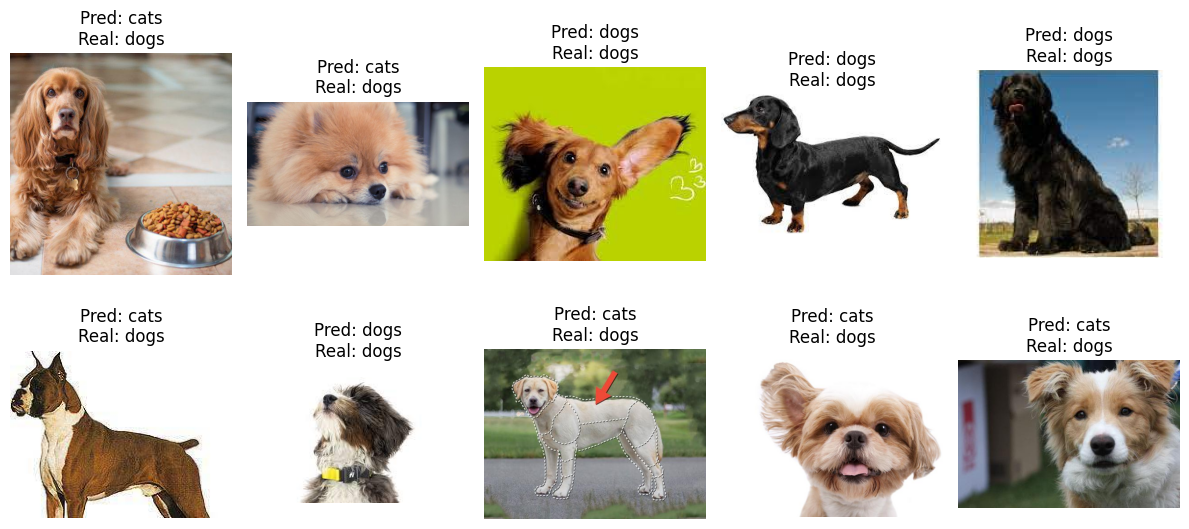

In [54]:
import matplotlib.pyplot as plt
# Function to predict the class of a single image
def predict_image(image_path, model, transform, classes):
    image = Image.open(image_path).convert('RGB') # Ensure image is in RGB format
    image = transform(image).unsqueeze(0) # Apply transformations and add batch dimension
    image = image.to(device) # Move image to the device
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
    return classes[predicted.item()]

# Define the class names
classes = train_dataset.classes # Get class names from the training dataset

# Get the class to index mapping
class_to_idx = train_dataset.class_to_idx

# Get a list of image paths from the test set (adjust the number as needed)
num_images_to_display = 10
test_image_paths = []
test_image_labels = []

for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        images_in_class = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
        # Add images from this class until we reach the desired number or run out of images
        for img_path in images_in_class:
            if len(test_image_paths) < num_images_to_display:
                test_image_paths.append(img_path)
                test_image_labels.append(class_name)
            else:
                break
    if len(test_image_paths) == num_images_to_display:
        break


# Display the images with predictions and real labels
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
for i in range(num_images_to_display):
    image_path = test_image_paths[i]
    true_label = test_image_labels[i]
    predicted_class = predict_image(image_path, model, test_transforms, classes)

    img = Image.open(image_path)

    plt.subplot(2, 5, i + 1) # 2 rows, 5 columns
    plt.imshow(img)
    plt.title(f"Pred: {predicted_class}\nReal: {true_label}")
    plt.axis('off')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()